# Setup

In [1]:
# import the necessary modules
import numpy as np
import scipy as sp
from scipy.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from tqdm.auto import trange
from copy import deepcopy
import pickle
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms.functional
import torch.optim as optim
from torch.optim import lr_scheduler

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

# Helper to round integer to odd number
to_odd = lambda x: int(np.ceil(x) // 2 * 2 + 1)

In [2]:
%config InlineBackend.figure_format='retina'
plt.style.use('bmh')

In [3]:
# check if GPU is available
torch.cuda.is_available()

True

## Load the Data

In [15]:
# upload the mean speeds of sound for each fragment. This should take less than a second
sos_mean = np.load('/home/knaftchi_stanford_edu/HUnet/data/sos_mean.npy', allow_pickle=True)
sos_norm = np.load('/home/knaftchi_stanford_edu/HUnet/data/sos_norm.npy', allow_pickle=True)
CT_mean_HU = np.load('/home/knaftchi_stanford_edu/HUnet/data/CT_mean_HU.npy', allow_pickle=True)
CT_norm = np.load('/home/knaftchi_stanford_edu/HUnet/data/CT_norm.npy', allow_pickle=True)

In [16]:
# get the max and min mean velocities 
sos_max = max(sos_mean)
sos_min = min(sos_mean)

In [17]:
def rev_normalize(array_norm, array_max, array_min):
    array = array_norm * (array_max - array_min) + array_min
    
    return array

In [18]:
# specify where to save the figures
fig_path = '/home/knaftchi_stanford_edu/HUnet/figures/'
data_path = '/home/knaftchi_stanford_edu/HUnet/data/'
code_path = '/home/knaftchi_stanford_edu/HUnet/code/'

## Split the Data

As discussed in the data preprocessing notebook, we don't split our data into train-validation-test sets, due to the small size of the dataset. Instead, we split our dataset into 5 folds, each containing a training and a validation (development) set. After removing the 3 outliers that we identified via Mahalanobis distance, we are left with only 97 data points. Therefore, the first 4 folds will have 77 training and 20 validation, while the 5th fold will have 80 training and 17 validation skulls.  

Filter out the outliers:

In [19]:
# remove the outliers from normalized CT (input) and SOS (label)
sos_norm = np.delete(sos_norm, [37, 78, 93])
CT_norm = np.delete(CT_norm, [37, 78, 93])

In [20]:
# remove the outliers from mean SOS and mean HU input (for linear model)
sos_mean = np.delete(sos_mean, [37, 78, 93])
CT_mean_HU = np.delete(CT_mean_HU, [37, 78, 93])

In [21]:
train_input = CT_norm
train_label = sos_norm
# use the un-normalized data for the linear model
linear_train_input = CT_mean_HU
linear_train_label = sos_mean

In [23]:
k = 5
for i in range(5):
    if i < 4:
        idx = np.arange((i * 20), (i + 1) * 20)
        globals()['train_x_fold' + str(i+1)] = np.delete(train_input, idx)
        globals()['train_y_fold' + str(i+1)] = np.delete(train_label, idx)
        globals()['val_x_fold' + str(i+1)] = train_input[idx]
        globals()['val_y_fold' + str(i+1)] = train_label[idx]
        globals()['linear_train_x_fold' + str(i+1)] = np.delete(linear_train_input, idx)
        globals()['linear_train_y_fold' + str(i+1)] = np.delete(linear_train_label, idx)
        globals()['linear_val_x_fold' + str(i+1)] = linear_train_input[idx]
        globals()['linear_val_y_fold' + str(i+1)] = linear_train_label[idx]
    if i == 4:
        idx = np.arange(80, 97)    
        globals()['train_x_fold' + str(i+1)] = np.delete(train_input, idx)
        globals()['train_y_fold' + str(i+1)] = np.delete(train_label, idx)
        globals()['val_x_fold' + str(i+1)] = train_input[idx]
        globals()['val_y_fold' + str(i+1)] = train_label[idx]
        globals()['linear_train_x_fold' + str(i+1)] = np.delete(linear_train_input, idx)
        globals()['linear_train_y_fold' + str(i+1)] = np.delete(linear_train_label, idx)
        globals()['linear_val_x_fold' + str(i+1)] = linear_train_input[idx]
        globals()['linear_val_y_fold' + str(i+1)] = linear_train_label[idx]

# Models

## Linear Model
later talk about the linear fit and how we solve for the fit using least squares

In [24]:
def least_squares_fit(x_train, y_train, x_test, y_test):
    
    X = np.ones((len(x_train), 2))
    X[:, 0] = x_train
    Y = y_train.reshape(len(y_train), 1)
    
    # calculate the slope and intercept 
    m, b = np.linalg.inv(X.T @ X) @ X.T @ Y
    linear_fit = m * x_train + b
    linear_pred = m * x_test + b
    
    # calculate the r-squared
    r2 = pearsonr(x_train, y_train)[0]
    
    # calculate Mean Absolute Error (MAE) on validation set:
    MAE = np.mean(abs(y_test - linear_pred))
    
    # calculate the Mean Squared Error (MSE) on validation set:
    RMSE = np.sqrt(np.mean((y_test - linear_pred) ** 2))

    return linear_fit, linear_pred, r2, MAE, RMSE

Let's try the output of the ```least_squares_fit``` function on the first fold of the linear data. We will first fit a linear model to the training fold, and then make predictions with it in the subsequent plot.

In [25]:
linear_fit, linear_pred, r2, MAE, RMSE = least_squares_fit(linear_train_x_fold1, 
                                             linear_train_y_fold1,
                                            linear_val_x_fold1,
                                            linear_val_y_fold1)

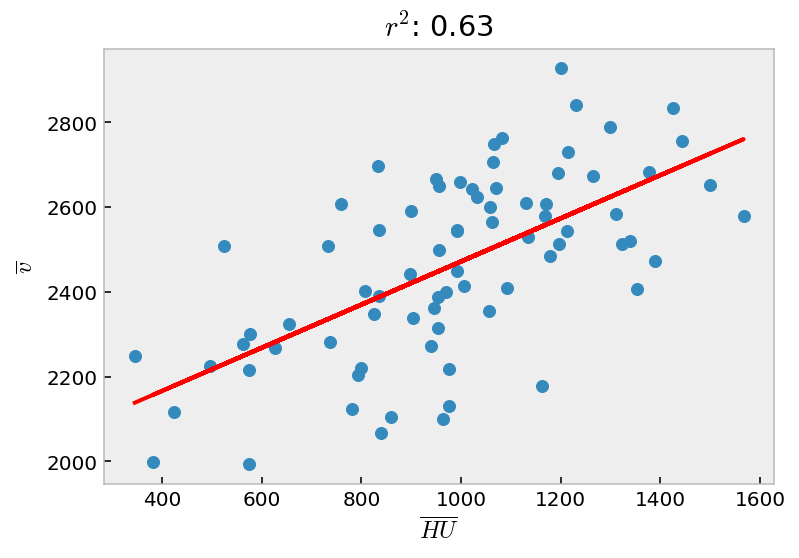

In [26]:
plt.scatter(linear_train_x_fold1, linear_train_y_fold1)
plt.plot(linear_train_x_fold1, linear_fit, color='r')
plt.title('$r^2$: ' + str(np.round(r2, 2)))
plt.xlabel(r'$\overline{HU}$')
plt.ylabel(r'$\overline{v}$')
plt.grid(False)
plt.show()

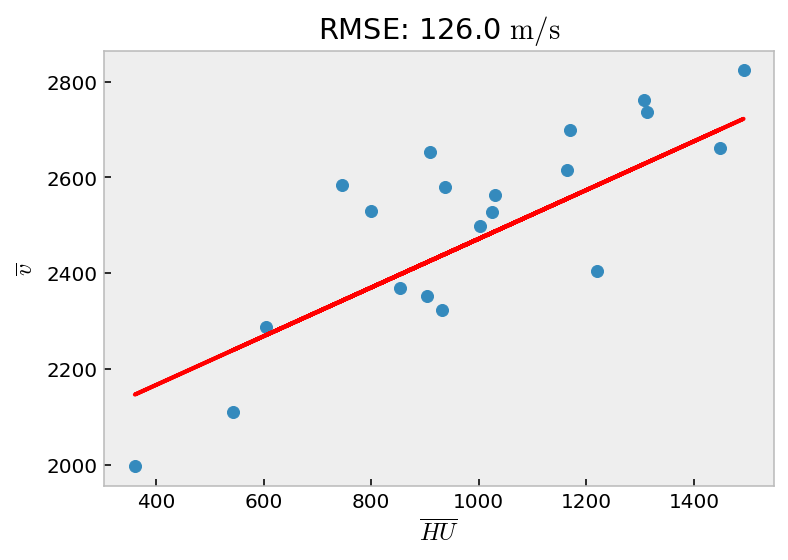

In [27]:
plt.scatter(linear_val_x_fold1, linear_val_y_fold1)
plt.plot(linear_val_x_fold1, linear_pred, color='r')
plt.title('RMSE: ' + str(np.round(RMSE)) + ' $\mathrm{m/s}$')
plt.xlabel(r'$\overline{HU}$')
plt.ylabel(r'$\overline{v}$')
plt.grid(False)
plt.show()

Next we will apply this function to every fold to get a comprehensive view of how this linear model is doing with respect to each fold to report more plausible mean performance metrics on this model. 

In [28]:
# save the training and validation data for later offline analysis 
train_val_matrix = []
for i in range(k):
    globals()['fold' + str(i+1)] = {
        'train_x':globals()['linear_train_x_fold' + str(i+1)],
        'train_y':globals()['linear_train_y_fold' + str(i+1)],
        'val_x':globals()['linear_val_x_fold' + str(i+1)],
        'val_y':globals()['linear_val_y_fold' + str(i+1)]
    }
    
    train_val_matrix.append(globals()['fold' + str(i+1)].copy())

In [29]:
# save the linear performance for later offline analysis 
linear_performance_matrix = []
for i in range(k):
    linear_performance_matrix.append(
        least_squares_fit(globals()['linear_train_x_fold' + str(i+1)],
                          globals()['linear_train_y_fold' + str(i+1)],
                          globals()['linear_val_x_fold' + str(i+1)],
                          globals()['linear_val_y_fold' + str(i+1)]))

In [18]:
# # uncomment to save the above matrices
# np.save(data_path +  'train_val_matrix.npy', train_val_matrix)
# np.save(data_path + 'linear_performance_matrix.npy', linear_performance_matrix)

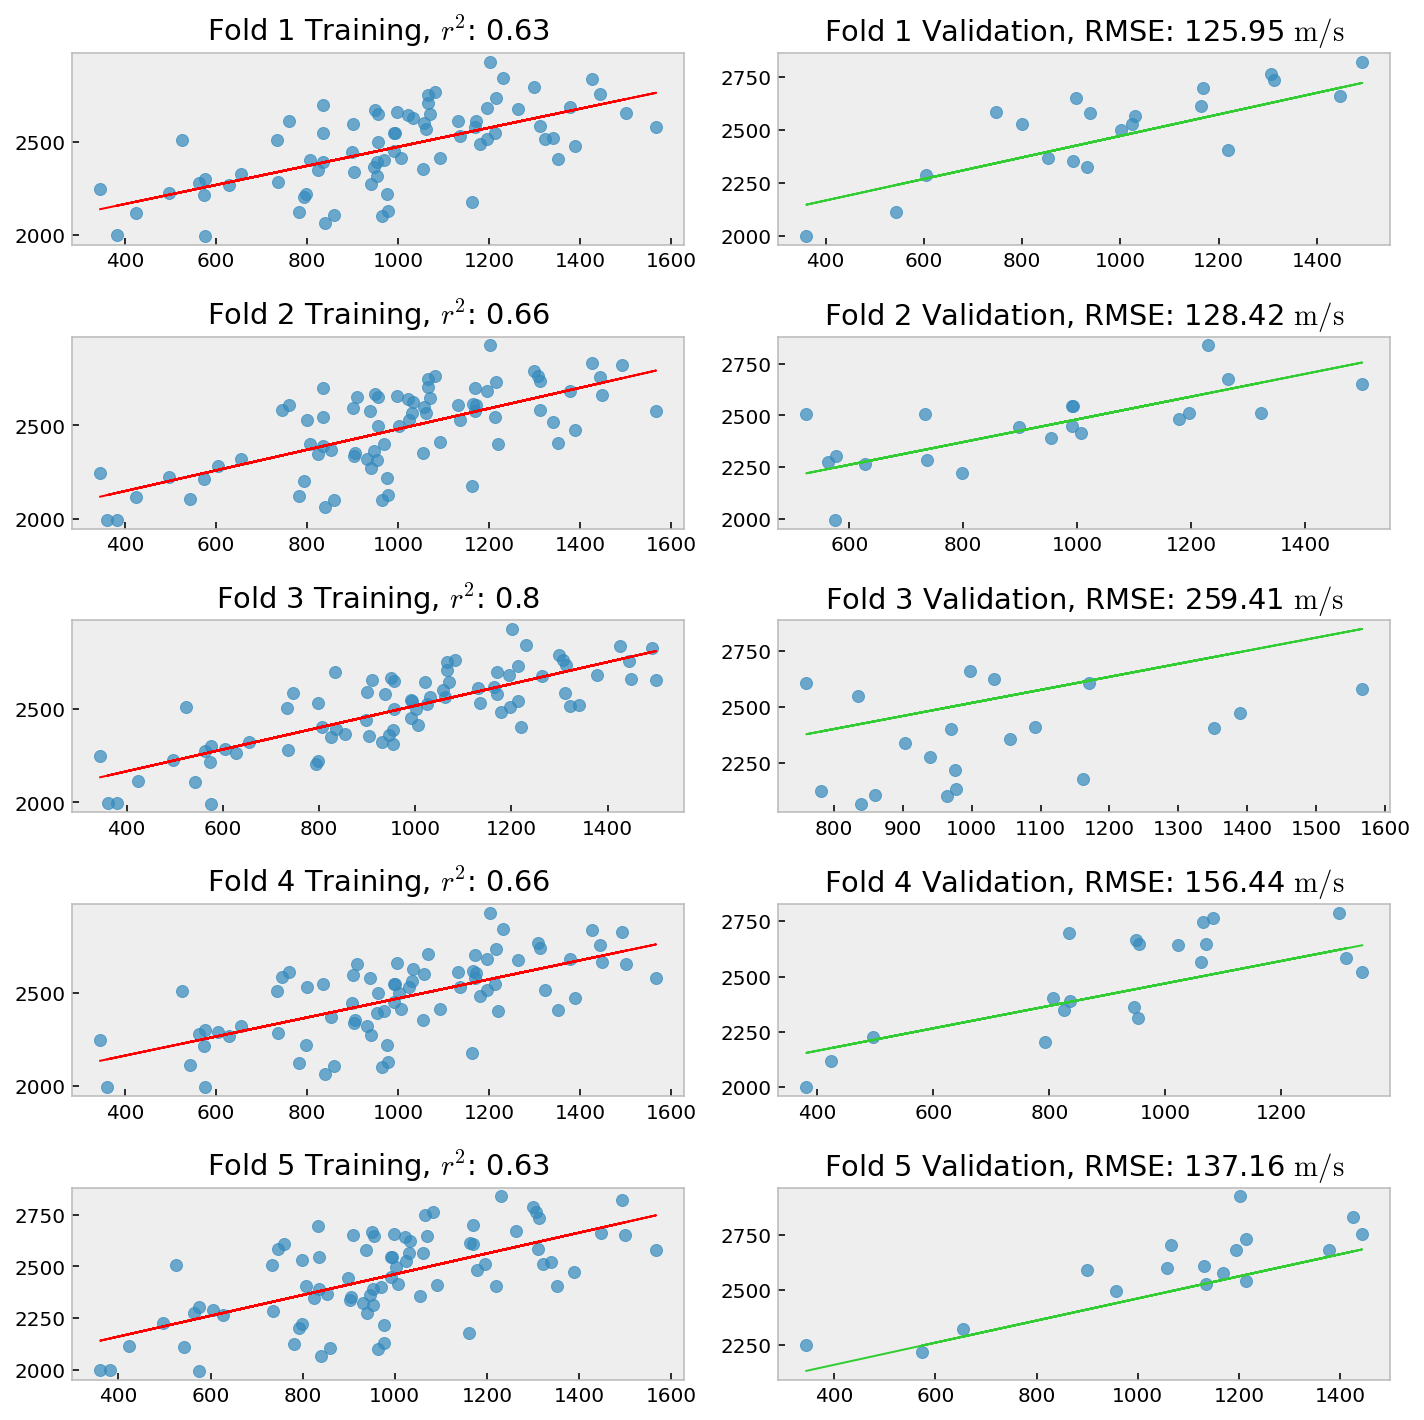

In [30]:
plt.figure(figsize=(10, 10))
for i in range(k):
    # training set
    plt.subplot(k, 2, (2 * i) + 1)
    plt.title('Fold ' + str(i+1) + ' Training, $r^2$: ' + 
              str(np.round(linear_performance_matrix[i][2], 2)))
    plt.scatter(globals()['linear_train_x_fold' + str(i+1)], 
                globals()['linear_train_y_fold' + str(i+1)], 
               alpha=0.7)
    plt.plot(globals()['linear_train_x_fold' + str(i+1)], 
             linear_performance_matrix[i][0], color='r', lw=1)
    plt.grid(False)

    # validation set 
    plt.subplot(k, 2, (2 * i) + 2)
    plt.title('Fold ' + str(i+1) + ' Validation, RMSE: ' + 
              str(np.round(linear_performance_matrix[i][4], 2)) + 
              ' $\mathrm{m/s}$')
    plt.scatter(globals()['linear_val_x_fold' + str(i+1)], 
                globals()['linear_val_y_fold' + str(i+1)], 
               alpha=0.7)
    plt.plot(globals()['linear_val_x_fold' + str(i+1)], 
             linear_performance_matrix[i][1], color='limegreen', lw=1)
    plt.grid(False)
    
    
plt.tight_layout()
#plt.savefig(fig_path + 'linear_model_performance.png', dpi=600)
plt.show()

In [31]:
linear_model_RMSE = np.mean([linear_performance_matrix[i][-1] for i in range(k)])
linear_model_MAE = np.mean([linear_performance_matrix[i][-2] for i in range(k)])

In [32]:
print(f'model RMSE: {np.round(linear_model_RMSE, 2)} m/s')
print(f'model MAE: {np.round(linear_model_MAE, 2)} m/s')

model RMSE: 161.48 m/s
model MAE: 135.99 m/s


### HUNet Model

At this point we are ready to build our HUNet model. 
First we will define a dataset class ```MicroCTDataset``` to handle our custom dataset. Then we will define rotations ```RandomRotation``` to be used with this custom dataset class. Next we will define a function ```evaluate_model``` to evaluate the model performance and a function ```train_model``` to train the model. Before training anything, we will further define our custom 4D dense layer ```DenseLayer``` as well as its corresponding transition layer ```TransitionLayer``` and put them together to build our version of dense blocks ```DenseBlock```. And lastly we will define the network architecture ```HUNet``` and start learning. 

In [33]:
# define a dataset class for the micro CT data
class MicroCTDataset(Dataset):
    def __init__(self, CT, sos, transform=None):
        self.CT = CT
        self.sos = sos
        self.transform = transform
            
    def __len__(self):   
        return len(self.sos)
    
    def __getitem__(self, idx):
        CT = to_t(self.CT[idx])
        sos = to_t(self.sos[idx])
        
        # pacakge the data into a dictionary of scans and sos
        datapoint = dict(CT=CT, sos=sos)
        # Apply transforms        
        if self.transform:
            datapoint = self.transform(datapoint)

        return datapoint

In [34]:
# to save on memory, we are only peforming 90-degree rotations
# to avaoid the need for extra padding 
class RandomRotation(object):
    def __call__(self, datapoint):
        CT = datapoint['CT']
        # generate a random number between 0 and 3 that determines the 
        # number of times you apply a 90-degree rotation
        k = np.random.randint(0, 4)
        # rotation is always in plane, so dims=(1, 2)
        dim = len(CT.size())
        rot_CT = torch.rot90(CT, k, dims=(dim-2, dim-1))

        return dict(CT=rot_CT, sos=datapoint['sos'])

In [35]:
def evaluate_model(model, test_dataset, loss_function):
    """Evaluates `model` on `test_datset`.

    Args:
    model (torch.nn.Module): PyTorch model to evaluate.
    test_dataset (ECoGDataset): Datset to use for testing. `model` should be
        capable of being called on batched parameters from `test_dataset`.
    loss_function (callable): Loss function to use for evaluating the model.

    Returns:
    loss (float): Mean loss on the testing set.
    preds (np.array): (`len(test_dataset)`, `num_classes`) array of model
        predictions (one per test set example).
    labels (np.array): (`len(test_dataset)`, `num_classes`) one-hot array of
        true labels (one per test set example).
    """
    # Set the model to evaluation mode so that the model weights remain frozen.
    model.eval()

    dataloader = DataLoader(test_dataset, batch_size=1)

    losses = []
    preds = []
    labels = []

    for datapoint in dataloader:
    # Disable autodiff gradient tracking, for efficiency.
        with torch.no_grad():
            labels.append(from_t(datapoint['sos']))
            output_t = model(datapoint['CT'])
            preds.append(from_t(output_t))
            loss_t = loss_function(output_t, datapoint['sos'])
            losses.append(loss_t.item())

    return np.mean(losses), np.array(preds).squeeze(), np.array(labels).squeeze()

In [36]:
def train_model(model, 
                train_dataset, 
                val_dataset,
                loss_func,  
                num_epochs=100,
                lr=0.0001, 
                momentum=0.9,
                lr_step_size=100,
                lr_gamma=0.1,
                batch_size=50, regularizer=None):
    # show the training progress 
    pbar = trange(num_epochs)
    pbar.set_description("---")
    # DataLoader iteratively loads the input data in given batch sizes. 
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)
    # optim.SGD performs stochastic gradient descent to optimize the weights. 
    # in this particular case, it is also using momentum. 
    optimizer = optim.SGD(model.parameters(), 
                         lr=lr, 
                         momentum=momentum)   
    # this scheduler reduces the learning rate for the optimizer by a factor 
    # of 0.1 every 100 epochs
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # create empty lists to store training and validation losses
    train_losses = []
    val_losses = []
    for epoch in pbar:
        # loop over training and validation sets
        for phase in ['train', 'val']:
            # if training, set the model to train mode, in which case it will 
            # update its weights via the optimizer method 
            if phase == 'train':
                model.train()
            # when evaluating, set the model to val mode so that there is no 
            # updating of the model weights
            else:
                model.eval()
            # these are running losses and in the end we will compute the average
            # by dividing over the running_size
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                CT = datapoint['CT']
                sos = datapoint['sos']
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        # zero out the gradients 
                        optimizer.zero_grad()
                        # compute the model prediction
                        output_t = model(CT)
                        # compute the loss
                        loss_t = loss_func(output_t, sos)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss_t += regularizer(model)
                        # compute the gradient of the loss with respect to the parameters 
                        loss_t.backward()
                        optimizer.step()
                else:
                    # store the true labels for prediction rate/error analysis 
                    # true_label.append(from_t(label))
                    # evaluate the model if not in train mode
                    output_t = model(CT)
                    # store the model predictions for prediction rate/error analysis 
                    # model_pred.append(from_t(output_t))
                    loss_t = loss_func(output_t, sos)

                # can't expect a negative loss
                assert loss_t >= 0
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # update the learning rate 
        scheduler.step()
        # show the last training loss and validation loss of the epoch 
        pbar.set_description("Epoch {:.1f} Train {:.3f} Val {:.3f}"\
                             .format(epoch+1, train_losses[-1], val_losses[-1]))
        # update the progress bar 
        pbar.update(1)

    return np.array(train_losses), np.array(val_losses)

In [37]:
class DenseLayer(nn.Module):
    def __init__(self, c_in, bn_size, k):
        super(DenseLayer, self).__init__()
        self.k = k
        self.add_module('conv_encode', nn.Conv3d(in_channels=c_in, 
                                            out_channels=bn_size * k, 
                                            kernel_size=(1, 1, 1)))
        self.add_module('conv_decode', nn.Conv3d(in_channels=bn_size * k,
                        out_channels=k, kernel_size=(3, 3, 3), padding=(1, 1, 1)))

    def forward(self, x):
        out = self.conv_encode(x)
        out = self.conv_decode(out)
        out = torch.cat([out, x], dim=1)
        return out

In [38]:
class TransitionLayer(nn.Module):
    def __init__(self, c_in):
        super(TransitionLayer, self).__init__()
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Conv3d(in_channels=c_in, out_channels=c_in // 2, 
                      kernel_size=(1, 1, 1),
                      bias=False),
            nn.AvgPool3d(kernel_size=(2, 2, 2),
                        stride=(2, 2, 2))
        )
        
    def forward(self, x):
        out = self.transition(x)
        return out

In [39]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, c_in, bn_size, k):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(c_in, bn_size, k))
            c_in = c_in + k 
            if i == num_layers - 1:
                layers.append(TransitionLayer(c_in))
    
        self.all_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.all_layers(x)
        return x

In [47]:
!nvidia-smi

Tue Oct 19 01:37:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 350W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [57]:
#Set seeds
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

def init_weights(m):
    if type(m) == nn.Conv3d:
        torch.nn.init.xavier_uniform_(m.weight)
        
class HUNet(nn.Module):
    def __init__(self):
        super(HUNet, self).__init__()
        
        # first conv 3D layer, input: (1,1,312,312,312), output: (1,16,154,154,154)
        self.initial_conv = nn.Sequential(
        nn.Conv3d(in_channels=1, out_channels=16, kernel_size=(5, 5, 5)),
        nn.MaxPool3d(kernel_size=(2, 2, 2)),
        nn.ReLU())
        
        # second conv 3D layer, input: (1,16,154,154,154), output: (1,16,80,80,80)
        self.reduc_conv = nn.Sequential(
        nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3, 3, 3), 
                 padding=(4, 4, 4)), 
        nn.MaxPool3d(kernel_size=(2, 2, 2)),
        nn.ReLU())
        
        # define the subsequent convolutional layers and the dense blocks:
        # initial_conv: (1,1,312,312,312) -> (1,16,154,154,154)
        # reduc_conv: (1,16,154,154,154) -> (1,16,80,80,80)
        # DenseBlock: (1,16,80,80,80) -> (1,104,40,40,40)
        # DenseBlock: (1,104,40,40,40) -> (1,244,20,20,20)
        # DenseBlock: (1,244,20,20,20) -> (1,506,10,10,10)
        # DenseBlock: (1,506,10,10,10) -> (1,509,5,5,5)
        # AdaptiveAvgPool32: (1,509,5,5,5) -> (1,509,1,1,1)
        # Flatten: (1,509,1,1,1) -> (1,509)
        
        self.conv_layers = nn.Sequential(
            self.initial_conv,
            self.reduc_conv,
            DenseBlock(6, 16, 2, 32),
            DenseBlock(12, 104, 2, 32),
            DenseBlock(24, 244, 2, 32),
            DenseBlock(16, 506, 2, 32),
            self.output_layer,
        )
        
    
        self.output_layer = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(509, 128),
            nn.ReLU(True),
            nn.Dropout(0.0),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.0),
            nn.Linear(64, 1)
        )
        
        # initialize the weights and place the model on the GPUs 
        self.conv_layers.apply(init_weights)
        self.conv_layers = nn.DataParallel(self.conv_layers, 
                                           device_ids=[0, 1]).cuda()
        

        
        
    def forward(self, x_):
        x_ = x_[None, ...]
        shape = list(x_.size())
        batch_size = int(shape[0])
        x = torch.zeros(1, 1, 312, 312, 312)
        # zero pad along the depth to ensure consistent 312 axis length 
        x[:, :, :shape[2], :, :] = x_
        self.conv_layers = self.conv_layers
        x = self.conv_layers(x)
        x = x.view(1, -1)

        return x.reshape([batch_size])

In [49]:
# build the dataset
train_x = train_x_fold5
train_y = train_y_fold5
val_x = val_x_fold5
val_y = val_y_fold5

train_dataset = MicroCTDataset(train_x, train_y, transform=RandomRotation())
val_dataset = MicroCTDataset(val_x, val_y, transform=None)

In [50]:
# initialize the model and move to device
torch.manual_seed(0)
model = HUNet()

loss_func = nn.MSELoss()

In [51]:
# train the HUNet model
print("Training the HUNet model...")
train_losses, val_losses = \
    train_model(model, 
                train_dataset, 
                val_dataset, 
                loss_func,
                momentum=0.9,
                num_epochs=400,
                lr=1e-4,
                lr_step_size=100,
                batch_size=1) 

Training the HUNet model...


  0%|          | 0/400 [00:00<?, ?it/s]

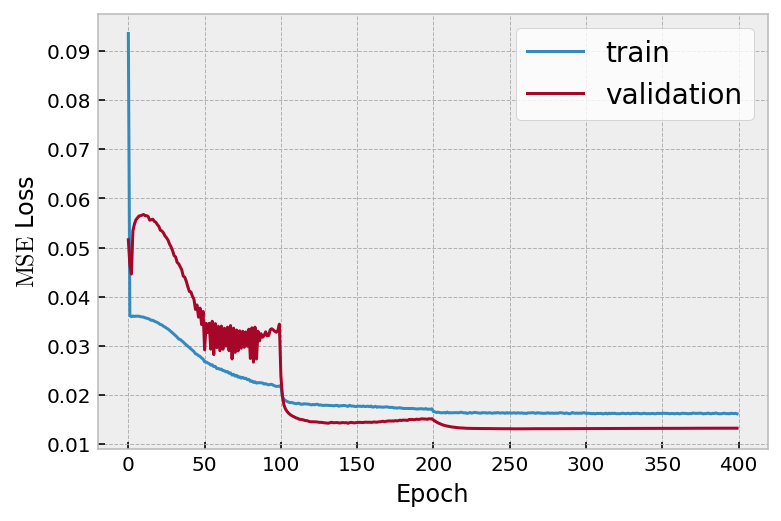

In [52]:
plt.plot(train_losses[:], label='train', lw=1.5)
plt.plot(val_losses[:], label='validation', lw=1.5)
plt.legend(facecolor='white', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel(r'$\mathrm{MSE}$ Loss')
#plt.savefig(fig_path + 'training_epochs_fold1', dpi=400)
plt.show() 

In [53]:
# uncomment to save the model
torch.save(model, code_path + 'DenseModel_fold5.pth')

In [50]:
# # uncomment to load the model
# model = HUNet()
# model = torch.load(code_path + 'DenseModel_fold5.pth')

In [51]:
# quick checl for model performance on the current fold
_, pred, true = evaluate_model(model, val_dataset, nn.MSELoss())

absolute_true = rev_normalize(true, sos_max, sos_min)
absolute_pred = rev_normalize(pred, sos_max, sos_min)

MSE = np.sqrt(np.mean((absolute_true - absolute_pred) ** 2))
print('HUNet MSE on the current fold: %.2f m/s' % np.round(MSE, 2))

HUNet MSE on the current fold: 128.96 m/s


### Reshuffle the test data
let's see how the performance is affected if we reshuffle the data 

In [52]:
import copy 
depth_shuffle = copy.deepcopy(val_x)
plane_shuffle = copy.deepcopy(val_x)

In [53]:
def infragment_shuffle(fragment):
    
    # first sum across the lateral axis to account for the effect of 
    # a major hole traversing the voxels along [:, 156, 156].
    reduced_fragment = np.sum(fragment, axis=1)
    
    # find the indices where the bone resides 
    bone_index = np.ravel(np.where(reduced_fragment[:, 156] != 0))
    
    # take the first and the last index for bone 
    i, j = bone_index[0], bone_index[-1]
    
    # shuffle between these two indices only 
    return np.random.shuffle(fragment[i:j, :, :])                                      

In [54]:
# shuffle the validation set 
for i in range(17):
    infragment_shuffle(depth_shuffle[i])
    np.random.shuffle(plane_shuffle[i].transpose(1, 2, 0))

visualize the depth-shuffle versus plane-shuffle effects 

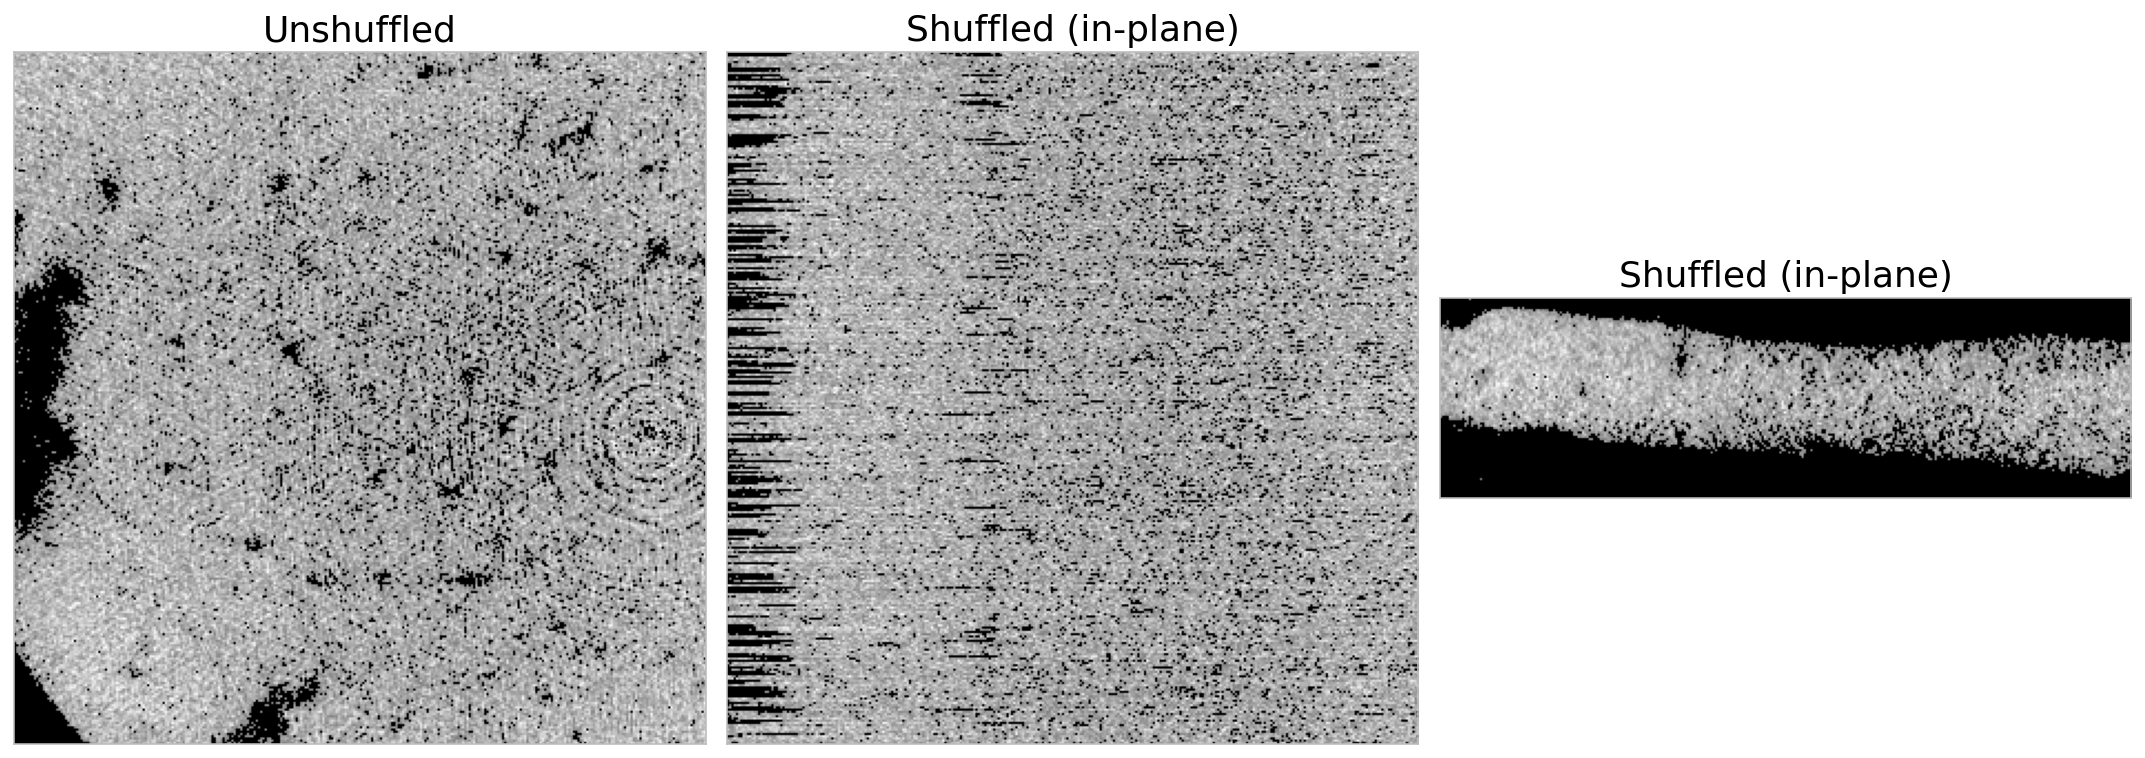

In [63]:
fragment_number = 0

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title('Unshuffled', fontsize=18)
plt.imshow(val_x[fragment_number][50, :, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('Shuffled (in-plane)', fontsize=18)
plt.imshow(plane_shuffle[fragment_number][50, :, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('Shuffled (in-plane)', fontsize=18)
plt.imshow(plane_shuffle[fragment_number][:, 156, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.tight_layout()
#plt.savefig(fig_path + 'in-plane-shuffle.png', dpi=600)
plt.show()

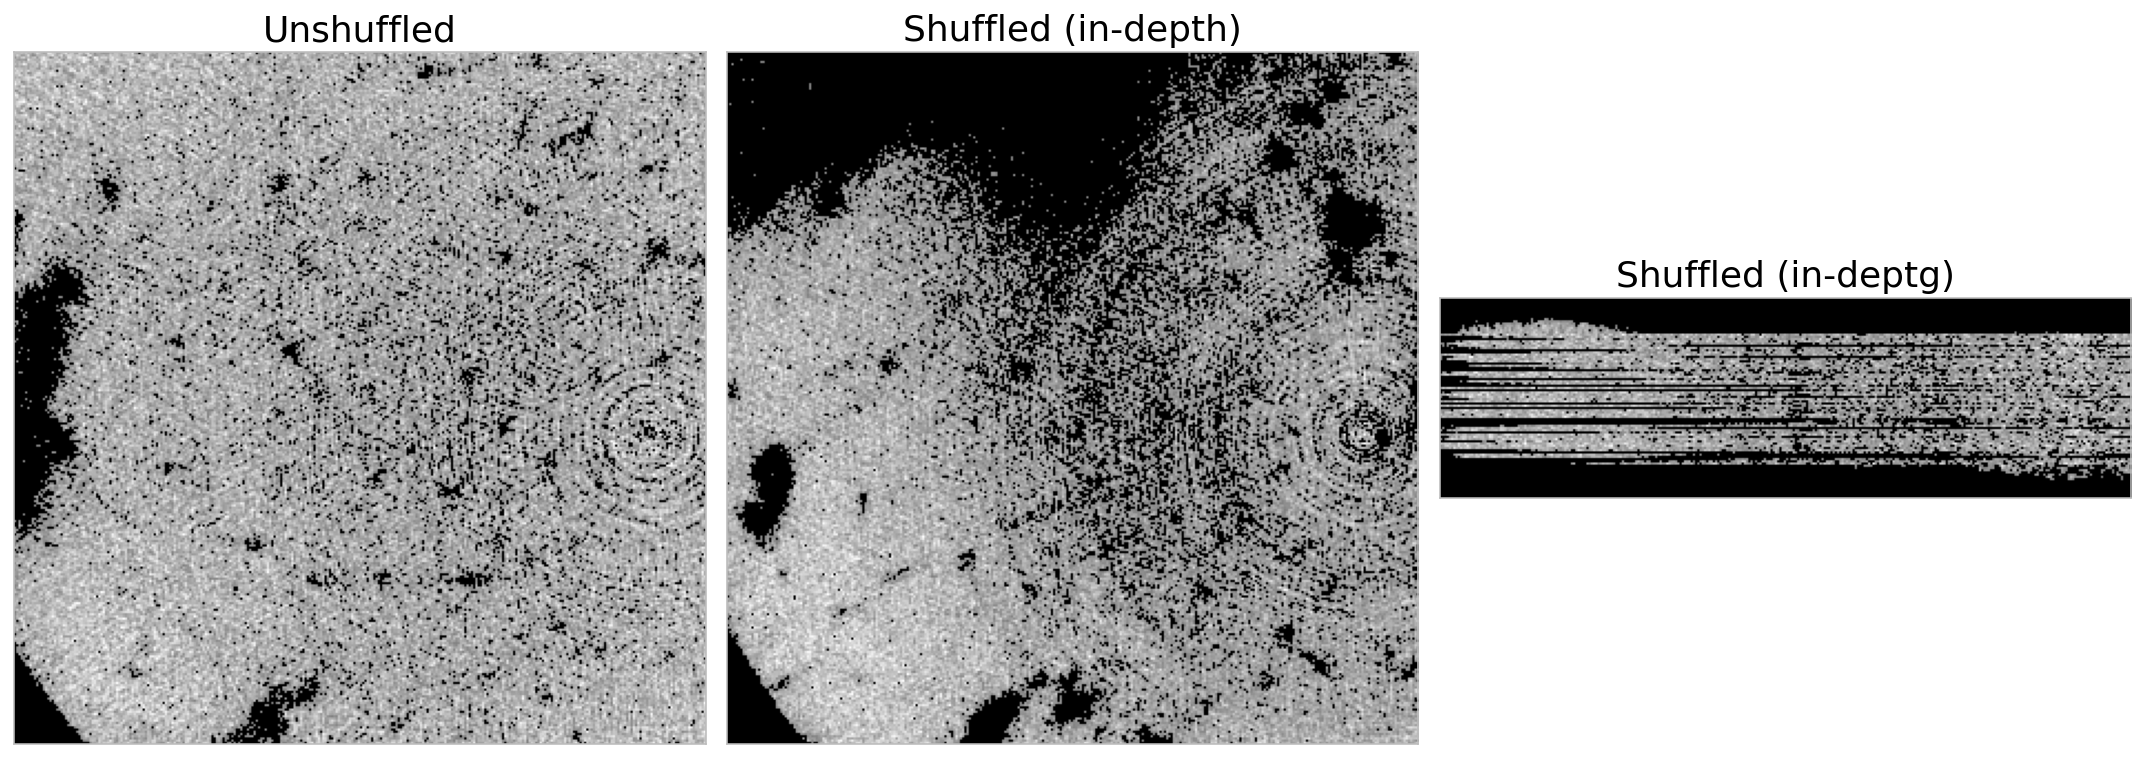

In [62]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title('Unshuffled', fontsize=18)
plt.imshow(val_x[fragment_number][50, :, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('Shuffled (in-depth)', fontsize=18)
plt.imshow(depth_shuffle[fragment_number][50, :, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('Shuffled (in-deptg)', fontsize=18)
plt.imshow(depth_shuffle[fragment_number][:, 156, :], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.tight_layout()
#plt.savefig(fig_path + 'in-depth-shuffle.png', dpi=600)
plt.show()

In [57]:
# build a dataset from the shuffled validation set 
depth_shuffled_dataset = MicroCTDataset(depth_shuffle, val_y, transform=None) 
plane_shuffled_dataset = MicroCTDataset(plane_shuffle, val_y, transform=None) 

In [58]:
# evaluate the model on the shuffled  validation set 
_, depth_shuff_pred, true = evaluate_model(model, depth_shuffled_dataset, nn.MSELoss())
_, plane_shuffled_pred, true = evaluate_model(model, plane_shuffled_dataset, nn.MSELoss())

In [59]:
# revert the predictions back to absolute sound speed values 
absolute_depth_shuff = rev_normalize(depth_shuff_pred, sos_max, sos_min)
absolute_plane_shuff = rev_normalize(plane_shuffled_pred, sos_max, sos_min)

In [60]:
# compute absolute residuals over speed of sound predictions
nn_res = abs(absolute_pred - absolute_true)
#lin_res = abs(linear_pred - absolute_true)
depth_shuff_res = abs(absolute_depth_shuff - absolute_true)
plane_shuff_res = abs(absolute_plane_shuff - absolute_true)

Save all the output into a meta dictionary that we can upload and compare. 

In [61]:
HUNet_performance_matrix = {'HUNet_MAE': MSE, 
             'train_losses': train_losses, 'val_losses': val_losses, 
             'model_prediction': pred, 'absolute_pred': absolute_pred, 
             'true_label': true, 'absolute_label': absolute_true,
            'depth_shuff_pred': absolute_depth_shuff,
            'plane_shuff_pred': absolute_plane_shuff}

NameError: name 'train_losses' is not defined

In [ ]:
# uncomment to save the HUNet_preformance_matrix 
np.save(data_path + 'Dense_performance_matrix_fold5.npy', HUNet_performance_matrix) 

In [68]:
test_idx = np.arange(1, 21)

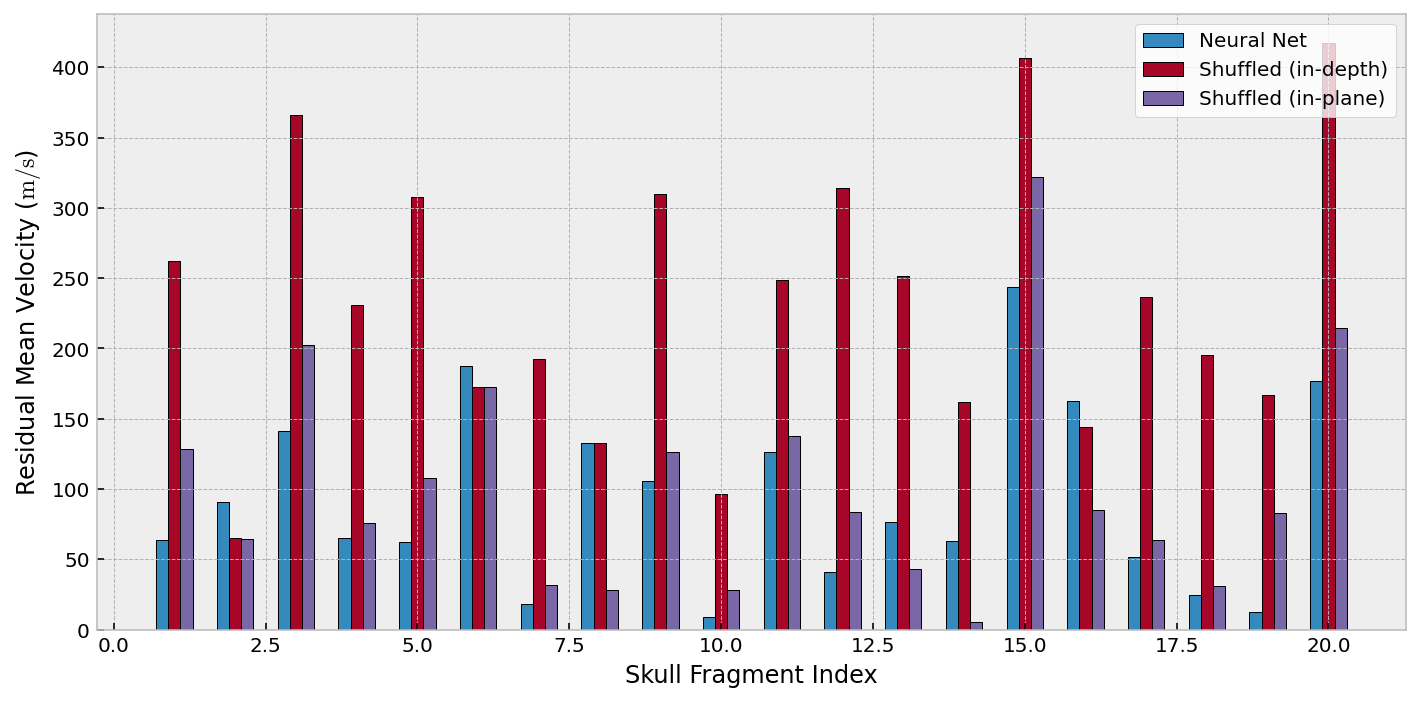

In [69]:
plt.figure(figsize=(10, 5))
plt.bar(test_idx-0.2, nn_res, width=0.2, label='Neural Net', edgecolor='k')
#plt.bar(test_idx-0.1, lin_res, width=0.2, label='Linear Model', edgecolor='k')
plt.bar(test_idx, depth_shuff_res, width=0.2, 
        label='Shuffled (in-depth)',  edgecolor='k')
plt.bar(test_idx+0.2, plane_shuff_res, width=0.2, 
        label='Shuffled (in-plane)', edgecolor='k')
plt.ylabel('Residual Mean Velocity ($\mathrm{m/s}$)')
plt.xlabel('Skull Fragment Index')
plt.legend(facecolor='white', loc='upper right')
plt.tight_layout()
#plt.savefig('/home/knaftchi_stanford_edu/HUnet/figures/res_scratch_shuffled', dpi=400)
plt.show()

In [50]:
# read_dictionary = np.load('/home/knaftchi_stanford_edu/HUnet/code/MetaData_tl_fw_2.npy',
#                           allow_pickle='TRUE').item()

## Visualize the model weights

In [467]:
model_weights = []
conv_layers = [] 

# get all the model modules as list
model_children = list(model.conv_layers.modules())

counter = 0 
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv3d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])  
                
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 122


In [217]:
model_children[0]

DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
      (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
      (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (2): DenseBlock(
      (all_layers): Sequential(
        (0): DenseLayer(
          (conv_encode): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (conv_decode): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (1): DenseLayer(
          (conv_encode): Conv3d(48, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (conv_decode): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (2): DenseLayer(
      

## Visualize feature maps 

In [287]:
sample_input = to_t(val_x_fold10[4])

In [289]:
x_ = sample_input[None, None, ...]
shape = list(x_.size())
batch_size = int(shape[0])
x = torch.zeros(1, 1, 312, 312, 312)
x[:, :, :shape[2], :, :] = x_

In [307]:
x = x.cuda(0)

In [414]:
# pass the image through all the layers
results = [conv_layers[0](x)]
for i in range(1, 6):
# pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

In [426]:
results[5].size()

torch.Size([1, 32, 80, 80, 80])

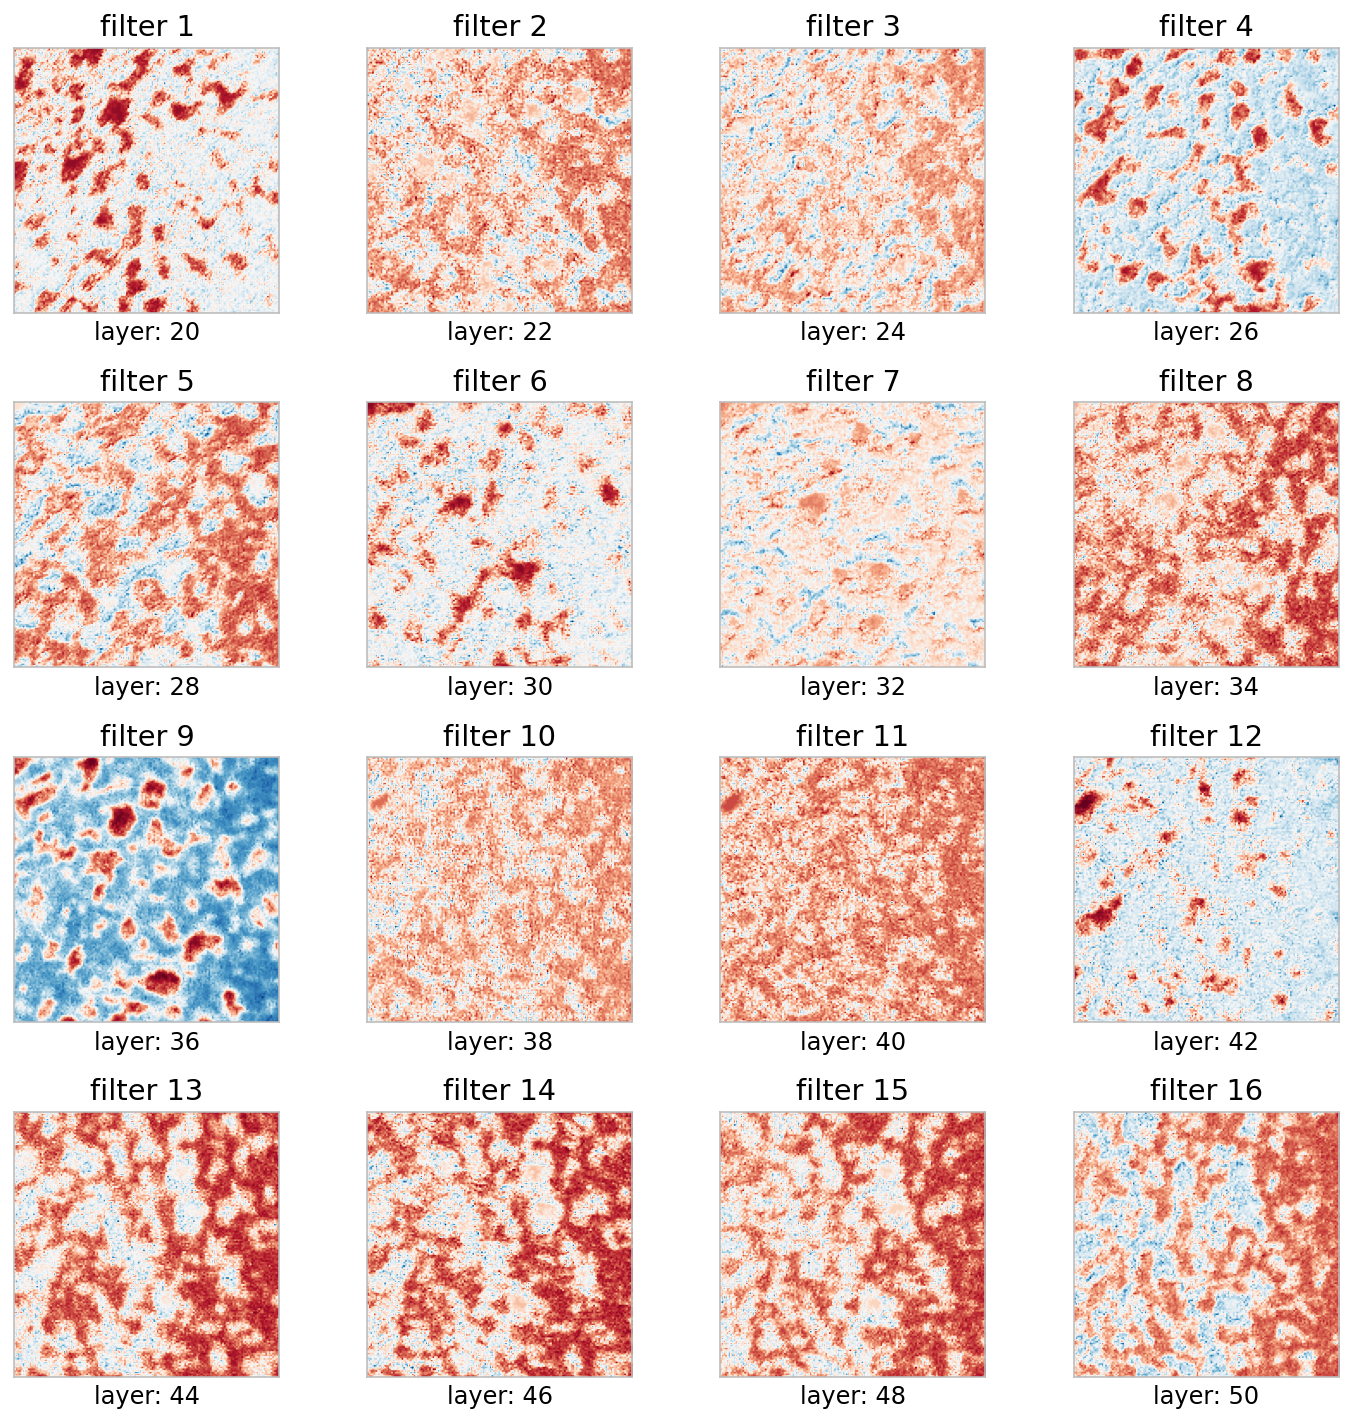

In [474]:
plt.figure(figsize=(10, 10))
filter_number = 1
starting_depth = 20
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(f'filter {i+1}')
    plt.imshow(from_t(results[filter_number][0, i][starting_depth + 2 * i]), cmap='RdBu')
    plt.grid(False)
    plt.xlabel(f'layer: {starting_depth + 2 * i}')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

#plt.savefig(fig_path + 'feature_maps', dpi=400)
plt.show()

## Saliency maps

To Do 